In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

clinical_df = pd.read_csv('clinical.tsv', sep='\t')
clinical_df['vital_status'] = np.where(clinical_df['days_to_death'].isna() | (clinical_df['days_to_death'] == "'--"), 1, 0)
conditions = [
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*3),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*3) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*5),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*5) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*10),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*10) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*20),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*20),
    (clinical_df['days_to_death'] == "'--") | (clinical_df['days_to_death'].isna())
]
values = [0, 1, 2, 3, 4, 5, 6]
clinical_df['status_strat'] = np.select(conditions, values)
clinical_df['vital_status'] = np.where(clinical_df['days_to_death'].isna() | (clinical_df['days_to_death'] == "'--"), 1, 0)
clinical_df['stage_m_strat'] = clinical_df['ajcc_clinical_m']
clinical_df['stage_m_strat'] = clinical_df['ajcc_pathologic_m'].map({'M0' : 0, 'MX' : 1})
clinical_df['stage_n_strat'] = clinical_df['ajcc_clinical_n'].replace("'--", np.NaN).map({'NX' : 0, 'N0' : 1, 'N1' : 2, 'N2' : 3, 'N2a' : 3, 'N2b' : 3, 'N2c' : 3, 'N3' : 4})
clinical_df['stage_strat'] = clinical_df['ajcc_clinical_stage'].replace("'--", np.NaN).map({'Stage I' : 0, 'Stage II' : 1, 'Stage III' : 2, 'Stage IVA' : 3, 'Stage IVB' : 3, 'Stage IVC' : 3})
clinical_df['stage_t_strat'] = clinical_df['ajcc_clinical_t'].replace("'--", np.NaN).map({'TX' : 0, 'T0' : 1, 'T1' : 2, 'T2' : 3, 'T3' : 4, 'T4' : 5, 'T4a' : 5, 'T4b' : 5})
clinical_df['diag_strat'] = clinical_df['morphology'].replace("'--", np.NaN).map({'8070/3' : 0, '8071/3' : 1, '8072/3' : 2, '8074/3' : 3, '8083/3' : 4})

clinical_df = clinical_df[list(set(clinical_df.columns) & set(['case_id','vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']))]

#df = pd.read_csv('rnaseq_all.tsv', sep='\t')
#df = pd.read_csv('rnaseq_s1.tsv', sep='\t')
df = pd.read_csv('rnaseq_s1_s2.tsv', sep='\t')
df = pd.merge(df, pd.read_csv('file_to_case.tsv', sep='\t'), on='file_id', how='left')
df = pd.merge(df, clinical_df, on='case_id', how='left')

df = df.drop(columns=['file_id', 'case_id'])

In [41]:
#status_counts = clinical_df['status_strat'].value_counts().sort_index()
#print(status_counts)


# Classification

In [46]:
for target in ['vital_status','status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']:
    df1 = pd.concat([df.iloc[:, :-7], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(X)

    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    print(target)
    print(cross_val_score(RandomForestClassifier(), X, y, cv=6, scoring='f1_micro'))

vital_status
[0.60638298 0.63829787 0.61702128 0.59574468 0.65957447 0.56382979]
status_strat


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


[0.55319149 0.55319149 0.55319149 0.4893617  0.5        0.5106383 ]
stage_m_strat
[0.76744186 0.71428571 0.73809524 0.76190476 0.73809524 0.76190476]
stage_n_strat
[0.5        0.46808511 0.50537634 0.50537634 0.49462366 0.52688172]
stage_strat
[0.5326087  0.55434783 0.52173913 0.54347826 0.54945055 0.50549451]
stage_t_strat
[0.36170213 0.32978723 0.27956989 0.33333333 0.37634409 0.2688172 ]
diag_strat


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


[0.85106383 0.86170213 0.86170213 0.86170213 0.85106383 0.85106383]


In [48]:
for target in ['vital_status','status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']:
    df1 = pd.concat([df.iloc[:, :-7], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(X)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score
    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)
    print(target)
    print(f1_score(y_test, classifier.predict(X_test), average='micro'))

vital_status
0.543859649122807
status_strat
0.5263157894736842
stage_m_strat
0.7692307692307693
stage_n_strat
0.42857142857142855
stage_strat
0.4909090909090909
stage_t_strat
0.30357142857142855
diag_strat
0.9298245614035088


# Dimensionality Rediction

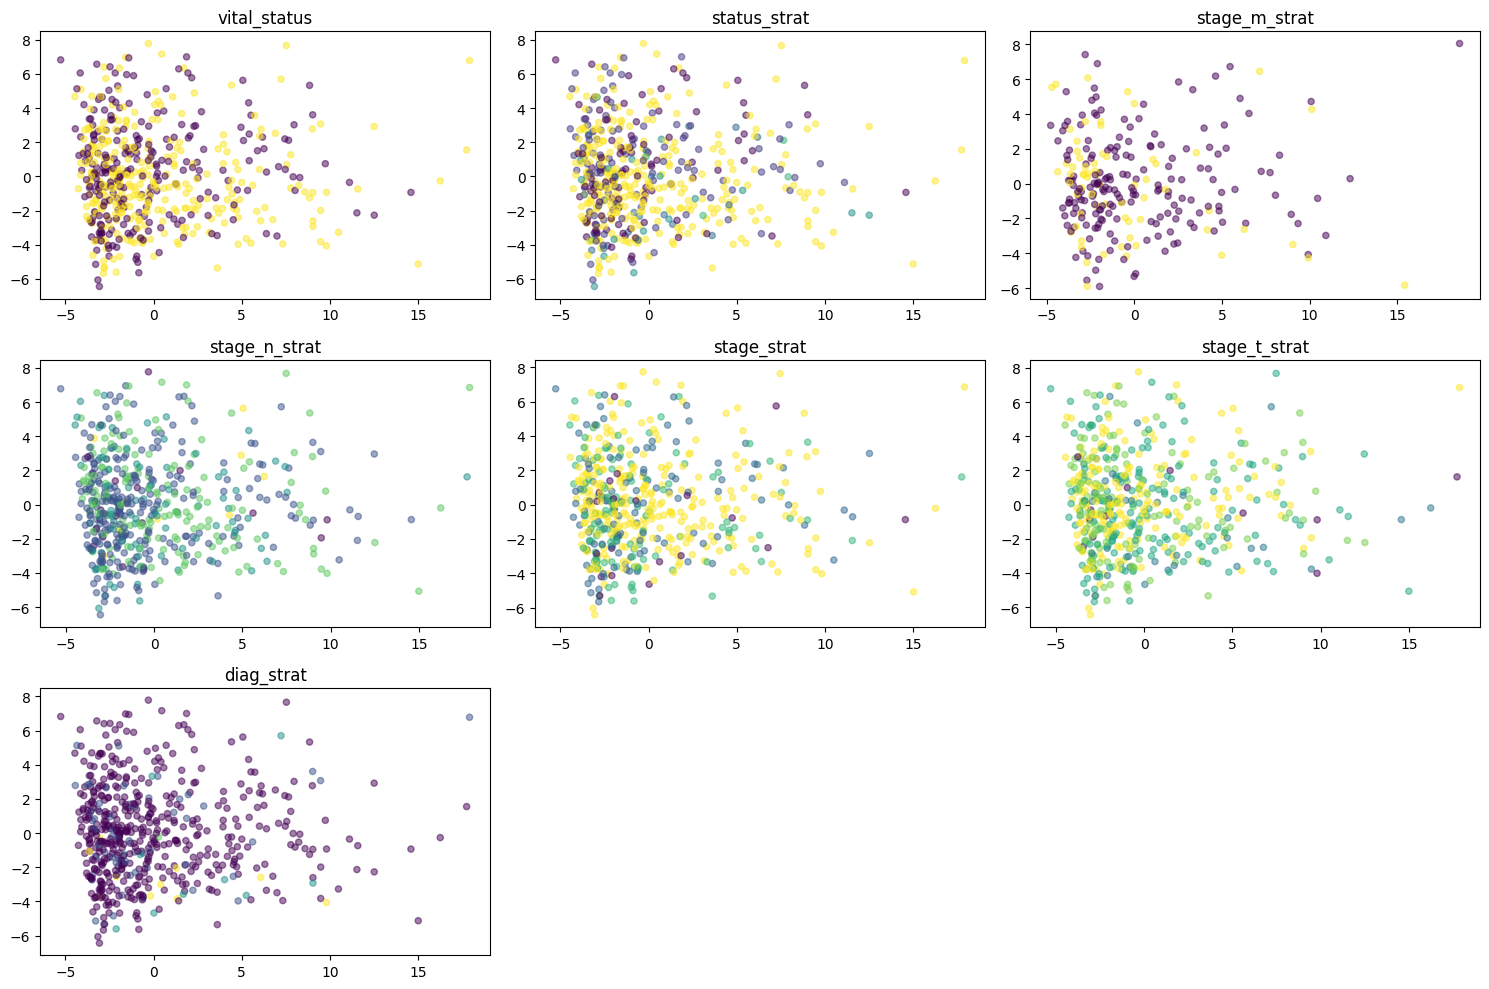

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

targets = ['vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']

plt.figure(figsize=(15, 10))

scaler = StandardScaler()
pca = PCA(n_components=2)

for i, target in enumerate(targets):
    df1 = pd.concat([df.iloc[:, :-7], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    X_scaled = scaler.fit_transform(X)
    principal_components = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    plt.subplot(3, 3, 1 + i)
    plt.title(target)
    plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis', s=20, alpha=0.5)

plt.tight_layout()
plt.show()


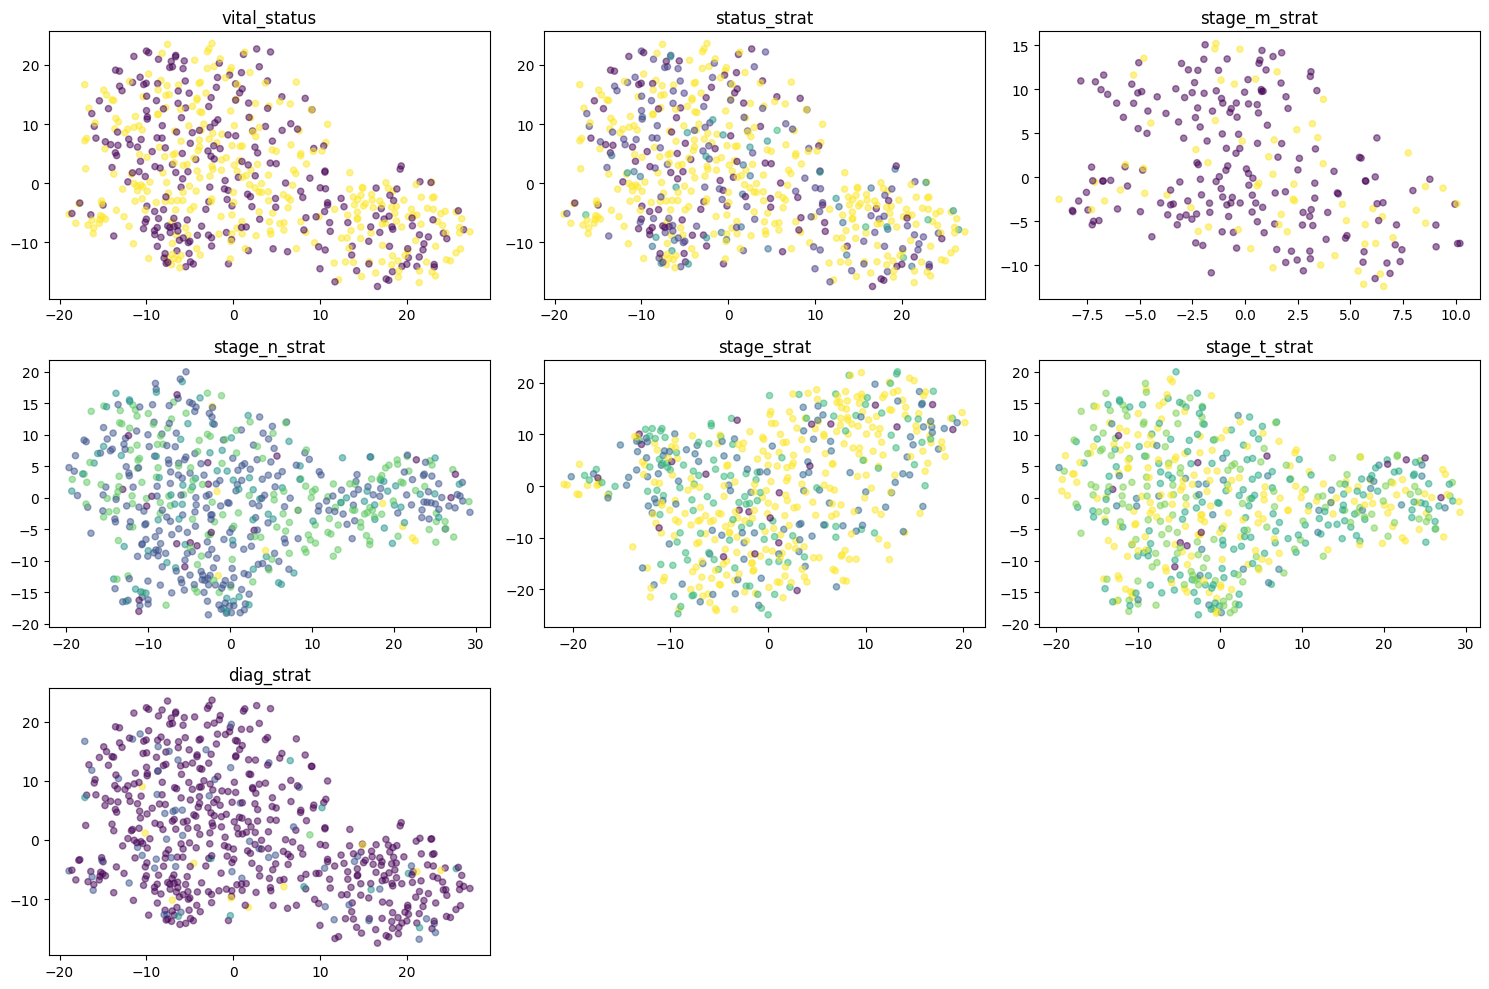

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

targets = ['vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']

plt.figure(figsize=(15, 10))

scaler = StandardScaler()

for i, target in enumerate(targets):
    df1 = pd.concat([df.iloc[:, :-7], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    X_scaled = scaler.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
    tsne_df = pd.DataFrame(data=tsne, columns=['PC1', 'PC2'])

    plt.subplot(3, 3, 1 + i)
    plt.title(target)
    plt.scatter(tsne_df['PC1'], tsne_df['PC2'], c=y, cmap='viridis', s=20, alpha=0.5)

plt.tight_layout()
plt.show()


# Autoencoders

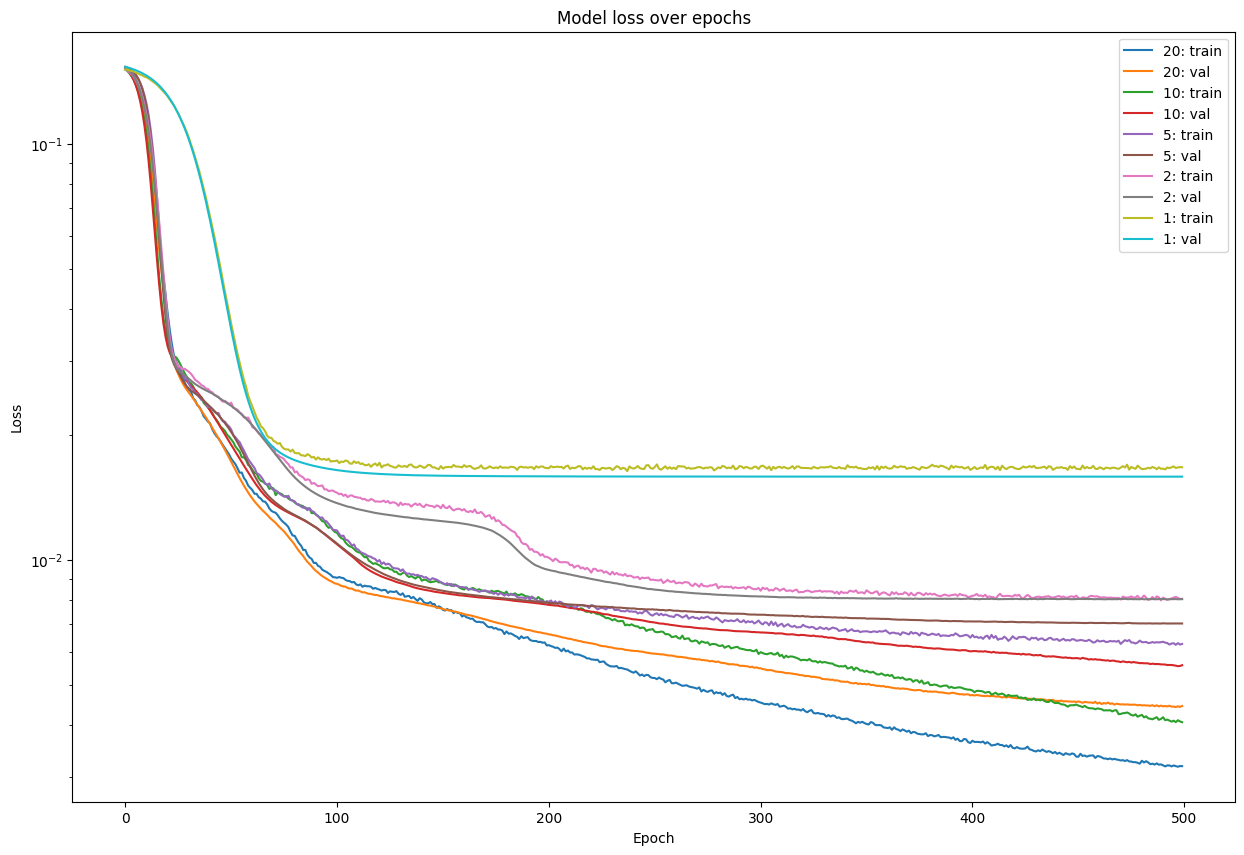

In [60]:
plt.figure(figsize = (15, 10))
for l in [20, 10, 5, 2, 1]:
    target = 'status_strat'
    df1 = pd.concat([df.iloc[:, :-7], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(X)

    from keras.layers import Input, Dense
    input_img = Input(shape=(X.shape[1],))
    encoded = Dense(X.shape[1], activation='relu')(input_img)
    encoded = Dense(X.shape[1], activation='relu')(encoded)
    encoded = Dense(l, activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='relu')(decoded)
    decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

    from keras.models import Model
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    decoder = Model(encoded, decoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    history = autoencoder.fit(X, X, epochs=500, batch_size=256, validation_split=0.2, verbose=0)

    plt.plot(history.history['loss'], label= str(l) + ': train')
    plt.plot(history.history['val_loss'], label=str(l) + ': val')
plt.title('Model loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [62]:
for l in [20, 10, 5, 2, 1]:
    target = 'status_strat'
    df1 = pd.concat([df.iloc[:, :-7], df[target]], axis=1).dropna()
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(X)

    from keras.layers import Input, Dense
    input_img = Input(shape=(X.shape[1],))
    encoded = Dense(X.shape[1], activation='relu')(input_img)
    encoded = Dense(X.shape[1], activation='relu')(encoded)
    encoded = Dense(l, activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='relu')(decoded)
    decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

    from keras.models import Model
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    decoder = Model(encoded, decoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    history = autoencoder.fit(X, X, epochs=500, batch_size=256, validation_split=0.2, verbose=0)
    encoded_imgs = encoder.predict(X)

    from sklearn.preprocessing import MinMaxScaler
    X = MinMaxScaler().fit_transform(encoded_imgs)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score
    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)
    print(target)
    print(f1_score(y_test, classifier.predict(X_test), average='micro'))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
status_strat
0.543859649122807
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
status_strat
0.47368421052631576
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
status_strat
0.5789473684210527
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
status_strat
0.45614035087719296
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
status_strat
0.3508771929824561
